In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as skimage
import math
%matplotlib inline
from skimage import color
import scipy.ndimage
import scipy.stats
import scipy.spatial.distance as dist
import scipy.optimize
from scipy.optimize import curve_fit
import random
import pickle
from tqdm import tqdm
import pandas as pd

### Data Generation
Determination of data points along the desired already driven surface on the image

In [64]:
from pynput import mouse

class MyException(Exception):pass

X = []
Y = []
NumberOfMouseClicks = 0
print('Click Origin')

def on_click(x, y, button, pressed):
    button = str(button)
    global NumberOfMouseClicks

    NumberOfMouseClicks = NumberOfMouseClicks + 1
    if NumberOfMouseClicks==1:
        print('Click Top Right')  
    if NumberOfMouseClicks==3:
        print('Draw the model, Right click to end')
        
    X.append(x)
    Y.append(y)

    if button!='Button.left':
        raise MyException(button)

def main(X,Y):
    with mouse.Listener(on_click=on_click) as listener:
        try:
            listener.join()
        except MyException as e:
            pass

    # drop duplicates
    X = X[::2]
    Y = Y[::2]


     # define scales from data
    origin = [X[0],Y[0]]
    topRight = [X[1],Y[1]]
    XminScale = origin[0]
    XmaxScale = topRight[0]
    YminScale = origin[1]
    YmaxScale = topRight[1]
    
    # input boundaries
    Xmin = float(origin[0])
    Xmax = float(topRight[0])
    Ymin = float(origin[1])
    Ymax = float(topRight[1])
    
    #Xmin = float(input('Input X-min: '))
    #Xmax = float(input('Input X-max: '))
    #Ymin = float(input('Input Y-min: '))
    #Ymax = float(input('Input Y-max: '))

    # drop extras
    X = X[2:15]
    Y = Y[2:15]


    # scale
    ## (old_value - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    Xplot = [(i - XminScale) / (XmaxScale - XminScale) * (Xmax - Xmin) + Xmin for i in X]
    Yplot = [(i - YminScale) / (YmaxScale - YminScale) * (Ymax - Ymin) + Ymin for i in Y]

    # print outputs
    print('Origin:     {}'.format([round(i, 2) for i in origin]))
    print('Top Right:  {}'.format([round(i, 2) for i in topRight]))
    print('X: {}'.format([round(i, 2) for i in Xplot]))
    print('Y: {}'.format([round(i, 2) for i in Yplot]))
    
if __name__ == '__main__':
    main(X,Y)

Click Origin
Click Top Right
Draw the model, Right click to end


Unhandled exception in listener callback
Traceback (most recent call last):
  File "C:\Users\pasha\python\lib\site-packages\pynput\_util\win32.py", line 380, in _handler
    converted = self._convert(code, msg, lpdata)
  File "C:\Users\pasha\python\lib\site-packages\pynput\_util\win32.py", line 395, in _convert
    raise NotImplementedError()
NotImplementedError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\pasha\python\lib\site-packages\pynput\_util\__init__.py", line 211, in inner
    return f(self, *args, **kwargs)
  File "C:\Users\pasha\python\lib\site-packages\pynput\_util\win32.py", line 384, in _handler
    self._handle(code, msg, lpdata)
  File "C:\Users\pasha\python\lib\site-packages\pynput\mouse\_win32.py", line 212, in _handle
    self.on_click(data.pt.x, data.pt.y, button, pressed)
  File "C:\Users\pasha\python\lib\site-packages\pynput\_util\__init__.py", line 127, in inner
    if f(*args) is False:

Origin:     [569, 1086]
Top Right:  [1790, 344]
X: [928.0, 923.0, 892.0, 888.0, 924.0, 935.0, 865.0, 783.0, 769.0, 744.0, 823.0, 846.0, 742.0]
Y: [947.0, 938.0, 927.0, 907.0, 938.0, 950.0, 910.0, 918.0, 937.0, 942.0, 919.0, 914.0, 909.0]


Saving the dummy data

In [65]:
data=(X[4:-1],Y[4:-1])
scale_lims=(X[1:3],Y[1:3])
with open("data/kriging data/kriging_data_.2%Mo_fig7.txt", "wb") as fp:   #Pickling
    pickle.dump(data, fp)
with open("data/kriging data/point_data_scaling_fig7.txt", "wb") as fp:
    pickle.dump(scale_lims,fp)

Loading the data and dropping the duplicates

In [66]:
with open("data/kriging data/kriging_data_.2%Mo_fig7.txt", "rb") as fp:   # Unpickling
    d = pickle.load(fp)
with open("data/kriging data/point_data_scaling_fig7.txt", "rb") as fp:   # Unpickling
    s = pickle.load(fp)
X=d[0]
Y=d[1]
X = X[::2]
Y = Y[::2]
X = X[0:-1]
Y = Y[0:-1]

Getting the data in order - seperation of columns

In [67]:
n=len(X)
new=[]
for i in np.arange(0,n):
    data=(X[i],Y[i])
    new.append(data)

In [68]:
#
df = pd.DataFrame(new, columns = ['X', 'Z'])
df['Z']=df['Z']*-1


#df=df.drop([109,110,111]) in case dropping some mistaken rows
df

,X,Z
0,928,-947
1,923,-938
2,892,-927
3,888,-907
4,924,-938
...,...,...
127,1492,-767
128,1490,-789
129,1473,-759
130,1449,-755


Checking the data by plotting the surface

Text(0.5, 1.0, 'Image of Digitized Model')

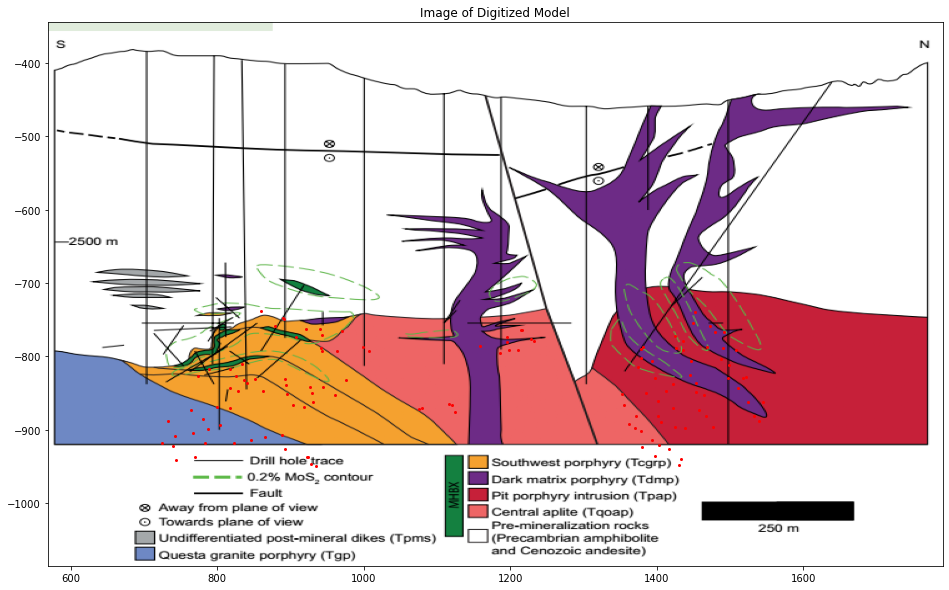

In [69]:
#to check the 2D data whether it has some errors
plt.figure(figsize=(20,10))
a=plt.imread("fig 7.png")

plt.imshow(a, extent=[s[0][0],s[0][1],-s[1][0],-s[1][1]])
plt.plot(df.iloc[:,0], df.iloc[:,1], "ro",marker=".", markersize=4)
plt.ylim(-s[1][0],-s[1][1])
plt.xlim(s[0][0],s[0][1])
plt.title("Image of Digitized Model")

### Additional Dimentions

In [70]:
n=len(df['Z'])
a=np.random.uniform(.2,.19,n)

In [71]:
#add 3rd dimention
df.loc[:, 'Y'] = '0'

#add the surface name for the point data
df.loc[:, 'grade_value'] = a
df.loc[:, 'grade'] = '.2%Mo'
df.loc[:, 'Fig'] = '7'
#df.loc[16:28, 'grade'] = 'grade12inside'
#df.loc[4:9,'formation']='rock72'
df=df[['X', 'Y', 'Z','grade_value','grade','Fig']]
df

,X,Y,Z,grade_value,grade,Fig
0,928,0,-947,0.196964,.2%Mo,7
1,923,0,-938,0.194479,.2%Mo,7
2,892,0,-927,0.196447,.2%Mo,7
3,888,0,-907,0.199309,.2%Mo,7
4,924,0,-938,0.196423,.2%Mo,7
...,...,...,...,...,...,...
127,1492,0,-767,0.197485,.2%Mo,7
128,1490,0,-789,0.195086,.2%Mo,7
129,1473,0,-759,0.192670,.2%Mo,7
130,1449,0,-755,0.193129,.2%Mo,7


In [72]:
#save the data at the end
df.to_csv(r'data/kriging data/kriging_data_.2%Mo_fig7.csv', index = False)